In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')


### Parse and Resample the Data

In [23]:
# Load data
df = pd.read_csv('household_power_consumption.txt', sep=';',parse_dates={'Datetime': ['Date', 'Time']},infer_datetime_format=True,
                 na_values='?',
                 low_memory=False)
# Convert 'Datetime' to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [24]:
# Set datetime index
df.set_index('Datetime', inplace=True)

In [25]:
# Convert 'Global_active_power' to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

In [26]:
# Resample daily energy consumption (kW)
daily_data = df['Global_active_power'].resample('D').sum().fillna(method='ffill')

In [27]:
# line plot on Global_active_power
fig = px.line(daily_data, title='Daily Energy Consumption (kW)')
fig.update_layout(yaxis_title='kW')
fig.show()

### Feature Engineering (Hour, Day, Weekend)

In [28]:
# extract day_of_week, is_weekend from Datetime
df_features = daily_data.reset_index()
df_features['day_of_week'] = df_features['Datetime'].dt.dayofweek
df_features['is_weekend'] = df_features['day_of_week'] >= 5
df_features.set_index('Datetime', inplace=True)


### Compare performance of ARIMA, Prophet, and XGBoost models


In [29]:
# ARIMA model
train = daily_data[:-30]
test = daily_data[-30:]

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit()

forecast_arima = results.forecast(steps=30)


In [30]:
# Prophet
df_prophet = daily_data.reset_index().rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet[:-30])

future = model.make_future_dataframe(periods=30)
forecast_prophet = model.predict(future)

# Extract last 30 days
forecast_prophet = forecast_prophet.set_index('ds')['yhat'][-30:]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjwvxd97b/plt307o7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjwvxd97b/0ok8xprv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33695', 'data', 'file=/tmp/tmpjwvxd97b/plt307o7.json', 'init=/tmp/tmpjwvxd97b/0ok8xprv.json', 'output', 'file=/tmp/tmpjwvxd97b/prophet_modelu8qv6tvb/prophet_model-20250718103839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:38:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:38:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [31]:
df_xgb = daily_data.reset_index()
df_xgb['day_of_week'] = df_xgb['Datetime'].dt.dayofweek
df_xgb['is_weekend'] = df_xgb['day_of_week'] >= 5
df_xgb['lag_1'] = df_xgb['Global_active_power'].shift(1)
df_xgb.dropna(inplace=True)

X = df_xgb[['day_of_week', 'is_weekend', 'lag_1']]
y = df_xgb['Global_active_power']

X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
forecast_xgb = model_xgb.predict(X_test)


Evaluation

In [32]:
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

mae_arima, rmse_arima = evaluate(test, forecast_arima)
mae_prophet, rmse_prophet = evaluate(test, forecast_prophet)
mae_xgb, rmse_xgb = evaluate(y_test, forecast_xgb)

print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}")
print(f"Prophet - MAE: {mae_prophet}, RMSE: {rmse_prophet}")
print(f"XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}")


ARIMA - MAE: 266.0422749889847, RMSE: 345.86862607868574
Prophet - MAE: 302.93140577805576, RMSE: 427.38586446677954
XGBoost - MAE: 348.8769759114583, RMSE: 472.16397130524973


### observation

The ARIMA model has the lowest MAE and RMSE values, indicating that it had the best performance in terms of forecasting accuracy compared to Prophet and XGBoost for this dataset.

### Plot actual vs. forecasted energy usage for visualization


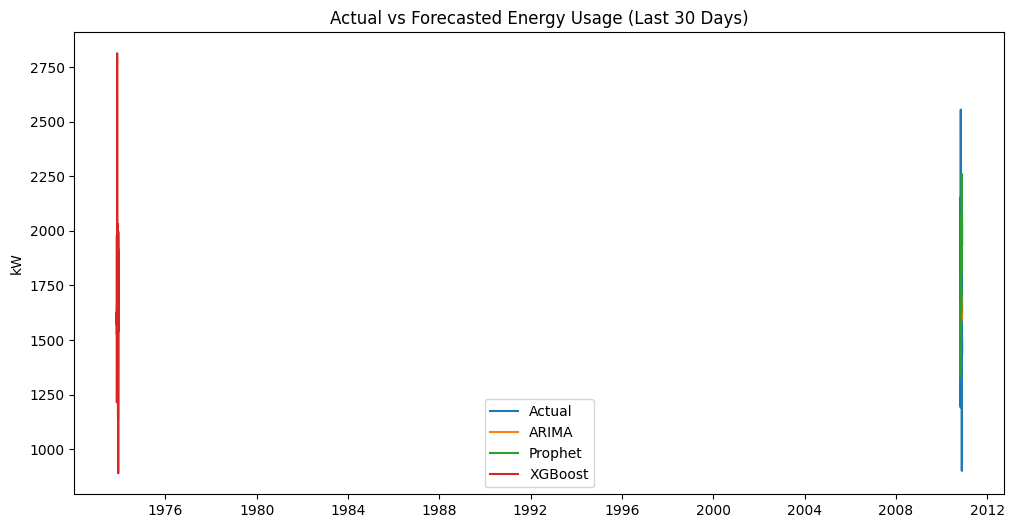

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA')
plt.plot(test.index, forecast_prophet, label='Prophet')
plt.plot(y_test.index, forecast_xgb, label='XGBoost')
plt.legend()
plt.title('Actual vs Forecasted Energy Usage (Last 30 Days)')
plt.ylabel('kW')
plt.show()


Here a breakdown of what each line represents:

- `Actual (Blue Line):` This line shows the true daily energy consumption values for the last 30 days of your dataset. It represents the ground truth that the models are trying to predict.
- `ARIMA (Orange Line):` This line shows the daily energy consumption forecasted by the ARIMA model for the same 30-day period.
- `Prophet (Green Line):` This line shows the daily energy consumption forecasted by the Prophet model.
- `XGBoost (Red Line):` This line shows the daily energy consumption forecasted by the XGBoost model.

By looking at how closely each colored line follows the blue "Actual" line, you can visually assess which model's forecasts are most accurate. In this particular graph, you can observe how well each model captures the fluctuations and trends in the actual energy consumption over the last 30 days. The closer a model's line is to the "Actual" line, the better its performance in forecasting. Based on the visual representation, you can see that the orange line `(ARIMA)` appears to follow the actual values more closely than the green `(Prophet)` and red `(XGBoost) `lines, especially during some of the peaks and dips. This visual observation supports the earlier evaluation metrics `(MAE and RMSE)` which indicated that ARIMA had the best performance among the three models.